In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import sklearn as sk
import scipy as sp
import matplotlib as pl
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import LatentDirichletAllocation
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree, ward
import re

# 1. Read and clean the data

In [2]:
data = pd.read_csv('Combined_News_DJIA2.csv')

print(data.shape)

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
for i in range (data.shape[0]):
    for j in range (1,data.shape[1]):
        temp=data.iloc[i,j]
        if type(temp)!=str:
            continue
        if temp[0]=='b':
            temp=re.sub('[^A-Za-z0-9]+', ' ', temp[2:-1])
        else:
            temp=re.sub('[^A-Za-z0-9]+', ' ', temp)
        data.iloc[i,j]=" ".join([stemmer.stem(k) for k in temp.split()])

(1984, 27)


In [3]:
data["Date"] = pd.to_datetime(data["Date"])
train = data[data['Date'] < '2015-01-01']
test = data[data['Date'] > '2014-12-31']

In [4]:
print(test.shape)
print(train.shape)

(378, 27)
(1606, 27)


In [5]:
data

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-15,0,mom of miss gay man too bad he s not a 21 year...,russia u s poland missil deal won t go unpunish,the govern has been accus of creat law that ha...,the italian govern has lash out at an influent...,gorbachev georgia start conflict in s ossetia,china fake more than your girlfriend ethnic mi...,the un s critic of freedom of express in the u...,russian general threaten nuclear strike on pol...,...,whi are redditor general support of russia inv...,johann hari we need to stop be such coward abo...,us offici have said that their militari presen...,israel clear troop who kill reuter cameraman,unenforc law encourag cop to escal their tacti...,what chines pollut realli look like,hacker kidnap and tortur inform post pictur as...,bush tell putin this aggress will not stand,georgia is all about the oil pipelin,rival say they plan to remov georgian presid
1,2008-08-18,1,in an afghan prison the major of femal prison ...,littl girl you re not ugli they are,pakistan s musharraf to resign leav the countri,tornado throw a bus in poland captur by one of...,britain s terror law have left me and my famil...,iran fire satellit into space,right of non muslim restrict by new maldiv con...,tour of tskhinvali undercut russian version of...,...,mi5 seek gay spi,new porn channel let canadian strut their stuff,the danger neighbor vladimir putin take on a p...,israel opinion page russian are saner,nato s hour,georgian presid saakashvili eat his tie on liv...,no chicken left behind anim rfid surveil arriv...,putin has given us an order that everyon must ...,nation dna databas grow on the gene of the innoc,mayor ask ugli women to visit his town
2,2008-08-19,1,man arrest and lock up for five hour after tak...,the us missil defenc system is the magic pud t...,schrder lambast for blame russian conflict on ...,offici 10 french soldier kill near kabul,these ten law make china a totalitarian wasteland,russia seiz us vehicl,muslim are onli 4 of denmark s 5 4 million peo...,taliban forc kill 10 french soldier and raid u...,...,brazil will play militari war game to defend r...,16 000 fine for british woman caught share gam...,102 year old grandma is oldest person on facebook,today 5 year ago august 19th 2003 bomb of the ...,us nation ken haywood whose comput was found t...,taliban kill 10 french troop near afghan capit,not everybodi love offshor wind power in spain,taliban forc kill 10 french soldier and raid u...,pakistan is more democrat than america,blaze engulf egyptian parliament
3,2008-08-20,0,two elder chines women have been sentenc to a ...,the power of islam the human right council at ...,we had 55 time more militari soldier in the fi...,i live here on less than a dollar a month obam...,russia send aircraft carrier to syria,the american peopl should be etern grate to ol...,abkhazia offici appeal to russia for independ,russia warn of respons beyond diplomaci agains...,...,grote markt pic,russia has inform norway that it plan to cut a...,what are the aim of this war french opposit de...,bush cover up musharraf tie with al qaeda,mikhail gorbachev russia never want a war,german urg tougher law after new privaci scandal,the time of the wimp dialogu with russia is th...,1998 missil strike on bin laden may have backfir,for a moment let s forget everyth els and pay ...,the first solar radio station in argentina
4,2008-08-21,0,british resid held in guantanamo bay win legal...,chines may have kill 140 tibetan this week dal...,u s navi ship head to georgia,hacker uncov chines olymp fraud,if you ve ever wonder what kim jong il was lik...,russia s nuclear threat is more than word,czech presid i must protest aloud against the ...,50 of all food produc is wast befor it get use,...,russia condemn us missil deal,nato decis to freez relat with moscow and wash...,sweet sixteen or fraudul fourteen hacker unear...,if russia feel churlish they can pre

## Word Counts: CountVectorizer

In [6]:
cv_object = CountVectorizer(token_pattern = '[a-zA-Z]{2,}', 
                            lowercase = True, 
                            stop_words = 'english', 
                            #min_df = 3,
                            ngram_range = (3,6)  # previously (2,2)
                           )  # do we need to use a N-gram model?

# train set
# build a "single list of strings"
trainheadlines = []
for row in range(0,len(train.index)):
    trainheadlines.append(' '.join(str(x) for x in train.iloc[row,2:27]))
train_mat = cv_object.fit_transform(trainheadlines)

# test set
testheadlines = []
for row in range(0,len(test.index)):
    testheadlines.append(' '.join(str(x) for x in test.iloc[row,2:27]))
test_mat = cv_object.transform(testheadlines)

In [7]:
# summary
# dimensions
print(train_mat.shape)
print(test_mat.shape)

# top 30 words
print(cv_object.get_feature_names()[:30])
# no more stemming words

(1606, 1715375)
(378, 1715375)
['aa pakistan acquit', 'aa pakistan acquit girl', 'aa pakistan acquit girl blasphemi', 'aa pakistan acquit girl blasphemi charg', 'aaa credit rate', 'aaa credit rate australia', 'aaa credit rate australia lead', 'aaa credit rate australia lead small', 'aaa credit rate happen', 'aaa credit rate happen pari', 'aaa credit rate happen pari abl', 'aaa credit rate moodi', 'aaa credit rate moodi women', 'aaa credit rate moodi women arrest', 'aaa rate assign', 'aaa rate assign toxic', 'aaa rate assign toxic structur', 'aaa rate assign toxic structur financ', 'aaa rate ireland', 'aaa rate ireland surviv', 'aaa rate ireland surviv bank', 'aaa rate ireland surviv bank downgrad', 'aaa rate polish', 'aaa rate polish soldier', 'aaa rate polish soldier kill', 'aaa rate polish soldier kill afghanistan', 'aaa seal approv', 'aaa seal approv worthless', 'aaa seal approv worthless invest', 'aaa seal approv worthless invest agenc']


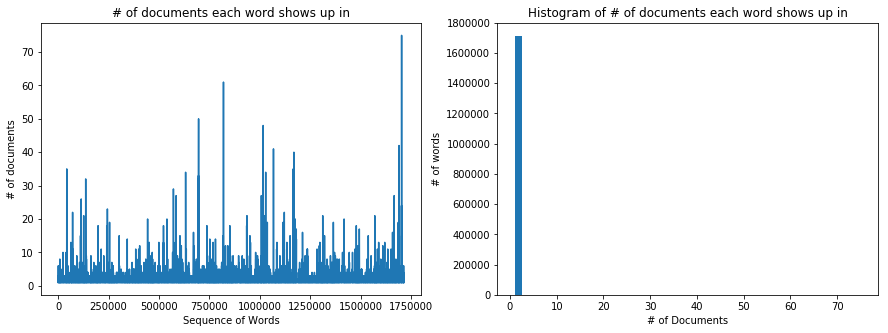

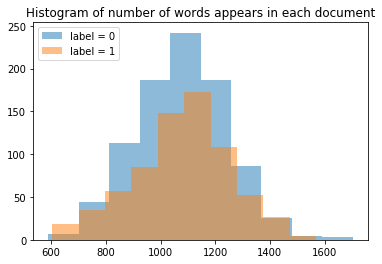

[1703573]
The word 'year old girl' appears in most documents.


In [8]:
freqs = sp.sparse.coo_matrix.sum(train_mat>0, axis = 0)
freqs = np.array(freqs.tolist()[0])

fig, axs = plt.subplots(1, 2, figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(freqs)
plt.title('# of documents each word shows up in')
plt.xlabel('Sequence of Words')
plt.ylabel('# of documents')

# hist
plt.subplot(1,2,2)
plt.hist(freqs, bins = 50)
plt.title('Histogram of # of documents each word shows up in')
plt.xlabel('# of Documents')
plt.ylabel('# of words')
plt.show()
  
num_words = sp.sparse.coo_matrix.sum(train_mat>0, axis = 1)
num_words = np.array(num_words.flatten())[0]
idx = (train['Label']==0)
#bins = np.linspace(120, 450, 40)
plt.hist(num_words[idx], alpha = 0.5, label = 'label = 0')
plt.hist(num_words[~idx],  alpha = 0.5, label = 'label = 1')
plt.legend(loc="upper left")
plt.title("Histogram of number of words appears in each document")
plt.show()

idx = np.argwhere(freqs == np.max(freqs)).flatten()
words = cv_object.get_feature_names()
print(idx)
for i in idx:
    print("The word '%s' appears in most documents." % (words[i]))

In [9]:
# logistic model
lm = LogisticRegression()
lm.fit(train_mat, train["Label"])

test_yhat = lm.predict(test_mat)

In [10]:
# confusion matrix
confusion = pd.crosstab(test["Label"], test_yhat, rownames=["Actual"], colnames=["Predicted"])
print(confusion)

# misclassification rate
mis = np.mean(test_yhat != test["Label"])
print(mis)

Predicted    0
Actual        
0          210
1          168
0.4444444444444444


## Word Frequency: TfidVectorizer

In [11]:
tfid = TfidfTransformer(use_idf=True)
train_mat2 = tfid.fit_transform(train_mat)
test_mat2 = tfid.transform(test_mat)

In [12]:
# logistic model
lm = LogisticRegression()
lm.fit(train_mat2, train["Label"])

test_yhat = lm.predict(test_mat2)

# confusion matrix
confusion = pd.crosstab(test["Label"], test_yhat, rownames=["Actual"], colnames=["Predicted"])
print(confusion)

# misclassification rate
mis = np.mean(test_yhat != test["Label"])
print(mis)

Predicted    0
Actual        
0          210
1          168
0.4444444444444444


## Available approaches:
1. Logistic regression/GAM ...
2. Bayesian Models
3. PCA/Matrix factorization
4. LDA/Clustering
5. RNN or LSTM (good for time series data)

Also, we have to deal with the stemming problem (use nltk)

# LDA

In [13]:
lda = LatentDirichletAllocation(n_components = 2, learning_method='batch', max_iter=100)
fit = lda.fit_transform(train_mat)   # theta, proportions of each topic in the dth document
topics = lda.components_/lda.components_.sum(axis=1)[:, np.newaxis]  # beta, distributions over words for each topic

In [14]:
print("Top 20 words for label 0")
idx = topics[0].argsort()[-20:][::-1]
words = np.array(words)
print(words[idx])

idx = topics[1].argsort()[-20:][::-1]
print("Top 20 words for label 1")
print(words[idx])

Top 20 words for label 0
['year old girl' 'kim jong il' 'human right watch' 'osama bin laden'
 'nobel peac prize' 'presid vladimir putin' 'human right group'
 'human right abus' 'world war ii' 'founder julian assang'
 'great barrier reef' 'nuclear power plant'
 'russian presid vladimir putin' 'russian presid vladimir' 'new york time'
 'wikileak founder julian' 'wikileak founder julian assang'
 'bashar al assad' 'presid barack obama' 'ban ki moon']
Top 20 words for label 1
['year old girl' 'kim jong il' 'osama bin laden' 'nobel peac prize'
 'human right watch' 'al jazeera english' 'world war ii'
 'presid vladimir putin' 'presid barack obama' 'nuclear power plant'
 'great barrier reef' 'bashar al assad' 'chancellor angela merkel'
 'fukushima nuclear plant' 'human right abus' 'human right activist'
 'anti govern protest' 'human right group' 'presid nicola sarkozi'
 'year old boy']


In [15]:
from sklearn.metrics import confusion_matrix

topic_prob = fit[:,0]
idx = sum(train['Label']==0)

y = (train['Label']==0)*1
y_hat = (topic_prob > 0.5)*1
print("Confusion matrix:")
print(confusion_matrix(y, y_hat))
mis = np.mean(y!=y_hat)
print("Train Misclassification rate:", mis)

Confusion matrix:
[[355 353]
 [456 442]]
Train Misclassification rate: 0.5037359900373599


In [16]:
testfit = lda.transform(test_mat)
y_test = (test['Label']==0)*1
topic_prob = testfit[:,0]
y_hat = (topic_prob>0.5)*1
print("Test Confusion matrix:")
print(confusion_matrix(y_test, y_hat))
mis = np.mean(y_test!=y_hat)
print("Test Misclassification rate:", mis)

Test Confusion matrix:
[[ 95  73]
 [ 99 111]]
Test Misclassification rate: 0.455026455026455


AUC:  0.5140873015873015


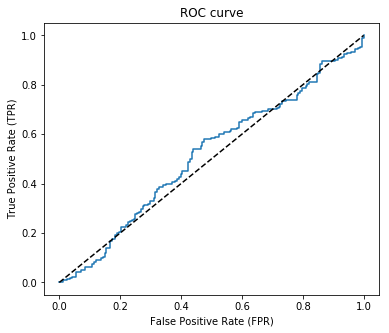

In [17]:
# ROC and AUC
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, topic_prob)
fig, ax = plt.subplots(figsize = (6,5))
# area under curve
roc_auc = sk.metrics.auc(fpr, tpr)

ax.plot(fpr, tpr)
ax.plot([0,1],[0,1],"k--")
ax.set(xlabel = "False Positive Rate (FPR)",
       ylabel = "True Positive Rate (TPR)",
       title = "ROC curve")
print("AUC: ",roc_auc)

In [18]:
# top 100
test_prob = testfit[:,0]
top100_id = np.argsort(test_prob)[::-1][:100]

rf_success_in_top_100 = np.mean(np.array(y_test)[top100_id])
print("fraction of Yes: ",rf_success_in_top_100)
print("base rate: ", np.mean(y_test))

fraction of Yes:  0.58
base rate:  0.5555555555555556


### after using TfidVectorizer

In [19]:
# after using TfidVectorizer
lda2 = LatentDirichletAllocation(n_components = 2, learning_method='batch', max_iter=100)
fit2 = lda2.fit_transform(train_mat2)   # theta, proportions of each topic in the dth document
topics2 = lda2.components_/lda2.components_.sum(axis=1)[:, np.newaxis]  # beta, distributions over words for each topic

In [20]:
print("Top 20 words for label 0")
idx = topics2[0].argsort()[-20:][::-1]
words = np.array(words)
print(words[idx])

idx = topics2[1].argsort()[-20:][::-1]
print("Top 20 words for label 1")
print(words[idx])

Top 20 words for label 0
['year old girl' 'kim jong il' 'osama bin laden' 'al jazeera english'
 'nobel peac prize' 'human right watch' 'nuclear power plant'
 'presid vladimir putin' 'human right abus' 'presid barack obama'
 'fukushima nuclear plant' 'chancellor angela merkel' 'world war ii'
 'founder julian assang' 'great barrier reef' 'world health organ'
 'new york time' 'ban ki moon' 'turkish prime minist'
 'wikileak founder julian']
Top 20 words for label 1
['year old girl' 'kim jong il' 'osama bin laden' 'human right watch'
 'nobel peac prize' 'human right group' 'world war ii' 'bashar al assad'
 'south china sea' 'presid vladimir putin' 'great barrier reef'
 'human right council' 'leader kim jong' 'nuclear power plant'
 'presid barack obama' 'presid bashar al' 'presid bashar al assad'
 'presid mahmoud ahmadinejad' 'al jazeera english'
 'australian prime minist']


Train Confusion matrix:
[[357 351]
 [440 458]]
Train Misclassification rate: 0.4925280199252802
Test Confusion matrix:
[[ 77  91]
 [115  95]]
Test Misclassification rate: 0.544973544973545


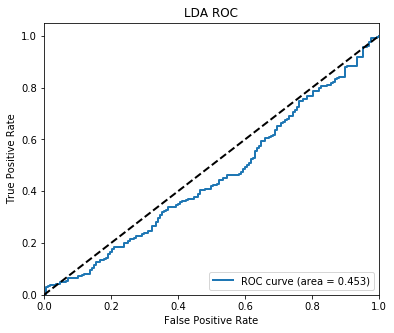

In [21]:
topic_prob2 = fit2[:,0]
idx = sum(train['Label']==0)

y = (train['Label']==0)*1
y_hat = (topic_prob2 > 0.5)*1
print("Train Confusion matrix:")
print(confusion_matrix(y, y_hat))
mis = np.mean(y!=y_hat)
print("Train Misclassification rate:", mis)

testfit = lda2.transform(test_mat)
y_test = (test['Label']==0)*1
topic_prob = testfit[:,0]
y_hat = (topic_prob>0.5)*1
print("Test Confusion matrix:")
print(confusion_matrix(y_test, y_hat))
mis = np.mean(y_test!=y_hat)
print("Test Misclassification rate:", mis)

# # ROC and AUC
# fpr, tpr, _ = roc_curve(y_test, topic_prob)
# fig, ax = plt.subplots(figsize = (6,5))
# # area under curve
# roc_auc = sk.metrics.auc(fpr, tpr)

# ax.plot(fpr, tpr)
# ax.plot([0,1],[0,1],"k--")
# ax.set(xlabel = "False Positive Rate (FPR)",
#        ylabel = "True Positive Rate (TPR)",
#        title = "LDA ROC curve",
#         label='ROC curve (area = %0.2f)'% roc_auc)
# plt.legend(loc="lower right")
# plt.show()
# print("AUC: ",roc_auc)

fpr, tpr, _ = roc_curve(y_test, topic_prob)
# area under curve
roc_auc = sk.metrics.auc(fpr, tpr)
# plot
plt.figure(figsize = (6,5))
lw = 2
plt.plot(fpr, tpr,
           lw=lw, label='ROC curve (area = %0.3f)'% roc_auc)
plt.plot([0, 1], [0, 1],color = "black", lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LDA ROC')
plt.legend(loc="lower right")
plt.show()

LDA models did not perform well. 

# Clustering

In [22]:
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import squareform

In [23]:
X = train_mat